# Project: Map recent Columbia animal complaint calls by city ward

In this starter project, we will:
- Download a CSV of recent police calls in Columbia, Missouri
- Manipulate the data so it can be mapped
- Filter the data to include only 'ANIMAL BITE' and 'ANIMAL COMPLAINT' calls
- Map those points on top of a map of city wards

... then we'll talk about where we could go from there.

Tools we will be using:
- Python's built-in [`datetime`](https://docs.python.org/3/library/datetime.html) module for working with date values
- `requests`, for fetching the data from the Internet
- `pandas`, for prepping and filtering the call data
- `shapely` and `geopandas`, which will help us turn the data into something we can map

A few reference links to maybe leave open in new tabs:
- [shapely documentation](http://toblerity.org/shapely/)
- [geopandas documentation](http://geopandas.org/)
- [Roberto Rocha's excellent NICAR 2017 notebook on Python GIS tools](https://github.com/robroc/GIS-with-python/blob/master/GIS%20with%20Python.ipynb)

{tk -- link to notebook on functions}

In [1]:
from datetime import date

import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline

In [21]:
def get_new_data(START_DATE=date(2018, 4, 2), END_DATE=date(2018, 4, 9), filename='data/cops.csv'):
    '''Download a CSV of police calls in Columbia, MO, for a given date range'''

    # get string of first date of police calls you want to grab
    start = START_DATE.strftime("%d/%m/%y")
    
    # get string of end date of police calls you want to grab
    end = END_DATE.strftime("%d/%m/%y")
    
    # set up the URL pattern you'd use to search for that date range
    URL_PATTERN = 'https://www.como.gov/CMS/911dispatch/police.php?' \
                  'Start_Date={}&End_Date={}&Submit=Filter'

    # build the URL
    url = URL_PATTERN.format(start, end)

    # create a session object
    # http://docs.python-requests.org/en/master/user/advanced/#session-objects
    s = requests.Session()

    # fetch the search URL
    s.get(url)

    # using that session, visit the CSV export URL
    r = s.get('https://www.como.gov/CMS/911dispatch/police_csvexport.php')

    # write the results to file
    with open(filename, 'wb') as f:
        for block in r.iter_content(1024):
            f.write(block)
    
    return filename

In [22]:
# uncomment the next line and run this cell to get new data
# get_new_data()

In [9]:
# read the police calls into a dataframe
calls = pd.read_csv('data/cops.csv')

# make sure the datetime values are being interpreted as datetimes, not strings
calls['CallDateTime'] = pd.to_datetime(calls['CallDateTime'], format='%m/%d/%Y %I:%M:%S %p')

# using lat/lng values, create a geometry column of shapely Points
calls['geometry'] = calls.apply(lambda row: Point(row.geox, row.geoy), axis=1)

In [18]:
# remove the calls without coordinates
non_null_calls = calls[(pd.notnull(calls.geox) & pd.notnull(calls.geoy))]

# filter for animal calls
animal_calls = non_null_calls[non_null_calls['ExtNatureDisplayName'].isin(['ANIMAL COMPLAINT', 'ANIMAL BITE'])]

# create a geodataframe from these calls, specifying the correct CRS
# https://epsg.io/102697
gdf = gpd.GeoDataFrame(animal_calls, crs={'init': 'ESRI:102697'})

# re-project to WGS-84
# http://spatialreference.org/ref/epsg/wgs-84/
gdf = gdf.to_crs({'init': 'epsg:4326'})

In [19]:
# read in a shapefile of city wards
city_wards = gpd.read_file('data/columbia-wards.shp')

# re-project to WGS-84
city_wards = city_wards.to_crs({'init': 'epsg:4326'})

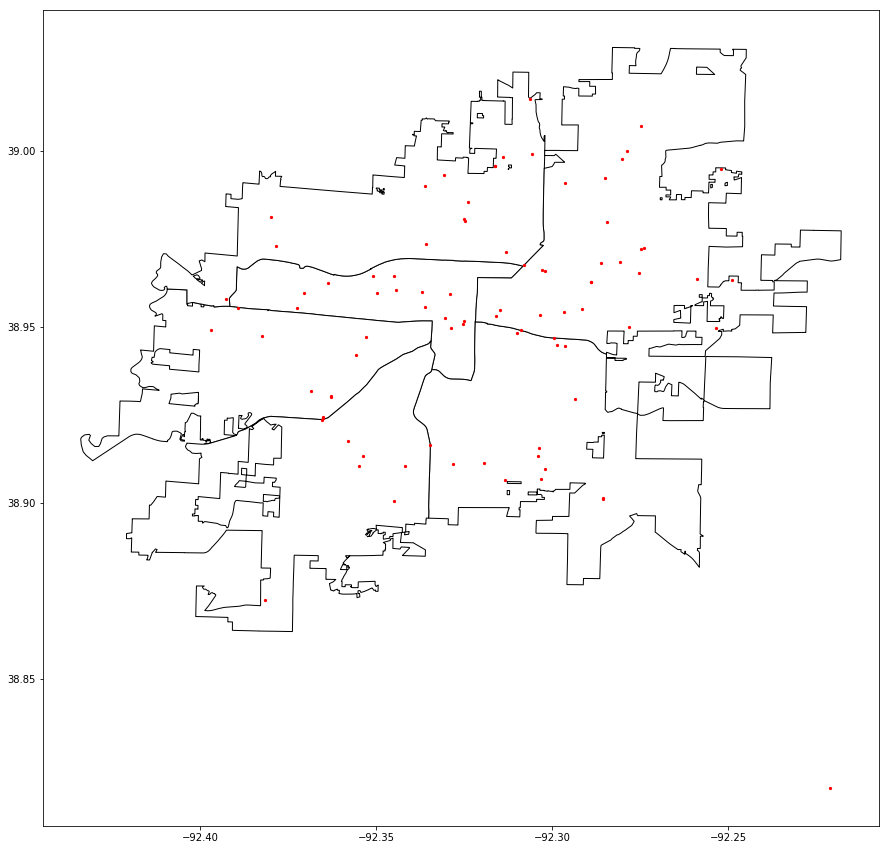

In [20]:
# plot basemap (city wards)
base = city_wards.plot(color='white', edgecolor='black', figsize=(30,15))

# plot calls
gdf.plot(ax=base, marker='o', color='red', markersize=5)